In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Pipelines:  TPU model train, upload, and deploy using google-cloud-pipeline-components

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/master/notebooks/official/pipelines/google_cloud_pipeline_components_TPU_model_train_upload_deploy.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/notebooks/blob/master/official/pipelines/google_cloud_pipeline_components_TPU_model_train_upload_deploy.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/pipelines/google_cloud_pipeline_components_TPU_model_train_upload_deploy.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview

This notebook shows how to use the components defined in [`google_cloud_pipeline_components`](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud) in conjunction with an experimental `run_as_aiplatform_custom_job` method, to build a [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines) workflow that trains a [custom model](https://cloud.google.com/vertex-ai/docs/training/containers-overview) using TPUs, uploads the model as a `Model` resource, creates an `Endpoint` resource, and deploys the `Model` resource to the `Endpoint` resource.

Learn more about [Training with TPU accelerators](https://cloud.google.com/vertex-ai/docs/training/training-with-tpu-vm). 

### Dataset

The dataset used for this tutorial is the [cifar10 dataset](https://www.tensorflow.org/datasets/catalog/cifar10) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). The version of the dataset you will use is built into TensorFlow. The trained model predicts which type of class an image is from ten classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, or truck.

### Objective

In this tutorial, you learn how to create a custom model using a pipeline with components from `google_cloud_pipeline_components` and a custom pipeline component you build.

<TODO>
In addition, you use the `kfp.v2.google.experimental.run_as_aiplatform_custom_job` method to train a custom model leveraging TPUs.

This tutorial uses the following Google Cloud ML services:

- `Vertex AI Training`
- `Vertex AI Pipelines`
- `Google Cloud Pipeline Components`

The steps performed include:

- Build a custom container for the custom model.
- Train the custom model with TPUs.
- Uploads the trained model as a `Model` resource.
- Creates an `Endpoint` resource.
- Deploys the `Model` resource to the `Endpoint` resource.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installations

Install the packages required for executing this notebook.

In [ ]:
! pip3 install --upgrade --quiet google-cloud-aiplatform \
                                 google-cloud-storage \
                                 'google-cloud-pipeline-components<2' \
                                 'kfp<2'

### Colab only: Uncomment the following cell to restart the kernel

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Before you begin

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID} --quiet

#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

#### Service Account

**If you don't know your service account**, try to get your service account using `gcloud` command by executing the second cell below.

In [ ]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [ ]:
import sys

IS_COLAB = "google.colab" in sys.modules
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step -- you only need to run these once per service account.

In [ ]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [ ]:
import google.cloud.aiplatform as aip

#### Vertex AI Pipelines constants

Setup up the following constants for Vertex AI Pipelines:

In [ ]:
PIPELINE_ROOT = "{}/pipeline_root/tpu_cifar10_pipeline".format(BUCKET_URI)

Additional imports.

In [ ]:
import kfp
from google_cloud_pipeline_components import aiplatform as gcc_aip
from kfp.v2.dsl import component
from kfp.v2.google import experimental

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [ ]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

### Set up variables

Next, set up some variables used throughout the tutorial.

#### Set hardware accelerators

You can set hardware accelerators for both training and prediction.



Set the variables `TRAIN_TPU/TRAIN_NTPU` to use a container training image supporting a TPU and the number of TPUs allocated and `DEPLOY_GPU/DEPLOY_NGPU` to user a container deployment image supporting a GPU and the number of GPUs allocated to the virtual machine (VM) instance. 

See the [locations where accelerators are available](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators).

Otherwise specify `(None, None)` to use a container image to run on a CPU.

In [1]:
from google.cloud.aiplatform import gapic

TRAIN_TPU, TRAIN_NTPU = (
    gapic.AcceleratorType.TPU_V3,
    8,
)  # Using TPU_V3 with 8 accelerators

DEPLOY_GPU, DEPLOY_NGPU = (gapic.AcceleratorType.NVIDIA_TESLA_K80, 1)

#### Set pre-built containers

Vertex AI provides pre-built containers to run training and prediction.

For the latest list, see [Pre-built containers for training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) and [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

In [ ]:
DEPLOY_VERSION = "tf2-gpu.2-9"

DEPLOY_IMAGE = "us-docker.pkg.dev/cloud-aiplatform/prediction/{}:latest".format(
    DEPLOY_VERSION
)

print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

#### Set machine types

Next, set the machine types to use for training and prediction.

- Set the variables `TRAIN_COMPUTE` and `DEPLOY_COMPUTE` to configure your compute resources for training and prediction.
 - `machine type`
     - `cloud-tpu` : used for TPU training. See the [TPU Architecture site for details](https://cloud.google.com/tpu/docs/system-architecture-tpu-vm)
     - `n1-standard`: 3.75GB of memory per vCPU
     - `n1-highmem`: 6.5GB of memory per vCPU
     - `n1-highcpu`: 0.9 GB of memory per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]

*Note: The following is not supported for training:*

 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs

*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*.

In [ ]:
MACHINE_TYPE = "cloud-tpu"

# TPU VMs do not require VCPU definition
TRAIN_COMPUTE = MACHINE_TYPE
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

In [ ]:
if not TRAIN_NTPU or TRAIN_NTPU < 2:
    TRAIN_STRATEGY = "single"
else:
    TRAIN_STRATEGY = "tpu"

EPOCHS = 20
STEPS = 10000

TRAINER_ARGS = [
    "--epochs=" + str(EPOCHS),
    "--steps=" + str(STEPS),
    "--distribute=" + TRAIN_STRATEGY,
]

# create working dir to pass to job spec
WORKING_DIR = f"{PIPELINE_ROOT}/model"

MODEL_DISPLAY_NAME = "tpu_train_deploy"
print(TRAINER_ARGS, WORKING_DIR, MODEL_DISPLAY_NAME)

## Create a custom container


We will create a directory and write all of our container build artifacts into that folder.

In [ ]:
CONTAINER_ARTIFACTS_DIR = "tpu-container-artifacts"

!mkdir {CONTAINER_ARTIFACTS_DIR}

In [ ]:
import os

### Write the Dockerfile

In [ ]:
dockerfile = """FROM python:3.8

WORKDIR /root

# Copies the trainer code to the docker image.
COPY train.py /root/train.py

RUN pip3 install tensorflow-datasets

# Install TPU Tensorflow and dependencies.
# libtpu.so must be under the '/lib' directory.
RUN wget https://storage.googleapis.com/cloud-tpu-tpuvm-artifacts/libtpu/20210525/libtpu.so -O /lib/libtpu.so
RUN chmod 777 /lib/libtpu.so

RUN wget https://storage.googleapis.com/cloud-tpu-tpuvm-artifacts/tensorflow/20210525/tf_nightly-2.6.0-cp38-cp38-linux_x86_64.whl
RUN pip3 install tf_nightly-2.6.0-cp38-cp38-linux_x86_64.whl
RUN rm tf_nightly-2.6.0-cp38-cp38-linux_x86_64.whl

ENTRYPOINT ["python3", "train.py"]
"""

with open(os.path.join(CONTAINER_ARTIFACTS_DIR, "Dockerfile"), "w") as f:
    f.write(dockerfile)

#### Training script

In the next cell, you write the contents of the training script, `train.py`. In summary:

- Get the directory where to save the model artifacts from the environment variable `AIP_MODEL_DIR`. This variable is set by the training service.
- Loads CIFAR10 dataset from TF Datasets (tfds).
- Builds a model using TF.Keras model API.
- Compiles the model (`compile()`).
- Sets a training distribution strategy according to the argument `args.distribute`.
- Trains the model (`fit()`) with epochs and steps according to the arguments `args.epochs` and `args.steps`
- Saves the trained model (`save(MODEL_DIR)`) to the specified model directory.

TPU specific changes are listed below:
- Added a section that finds the TPU cluster, connects to it, and sets the training strategy to TPUStrategy
- Added a section that saves the trained TPU model to the local device, so that it can be saved to the AIP_MODEL_DIR

In [ ]:
%%writefile {CONTAINER_ARTIFACTS_DIR}/train.py
# Single, Mirror and Multi-Machine Distributed Training for CIFAR-10

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
tfds.disable_progress_bar()

parser = argparse.ArgumentParser()
parser.add_argument('--lr', dest='lr',
                    default=0.01, type=float,
                    help='Learning rate.')
parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')
parser.add_argument('--steps', dest='steps',
                    default=200, type=int,
                    help='Number of steps per epoch.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='distributed training strategy')
args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Single Machine, single compute device
if args.distribute == 'single':
    if tf.test.is_gpu_available():
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
# Single Machine, multiple TPU devices
elif args.distribute == 'tpu':
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
# Single Machine, multiple compute device
elif args.distribute == 'mirror':
    strategy = tf.distribute.MirroredStrategy()
# Multiple Machine, multiple compute device
elif args.distribute == 'multi':
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

# Multi-worker configuration
print('num_replicas_in_sync = {}'.format(strategy.num_replicas_in_sync))

# Preparing dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def make_datasets_unbatched():
  # Scaling CIFAR10 data from (0, 255] to (0., 1.]
  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

  datasets, info = tfds.load(name='cifar10',
                            with_info=True,
                            as_supervised=True)
  return datasets['train'].map(scale).cache().shuffle(BUFFER_SIZE).repeat()


# Build the Keras model
def build_and_compile_cnn_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      optimizer=tf.keras.optimizers.SGD(learning_rate=args.lr),
      metrics=['accuracy'])
  return model

# Train the model
NUM_WORKERS = strategy.num_replicas_in_sync
# Here the batch size scales up by number of workers since
# `tf.data.Dataset.batch` expects the global batch size.
GLOBAL_BATCH_SIZE = BATCH_SIZE * NUM_WORKERS
MODEL_DIR = os.getenv("AIP_MODEL_DIR")

train_dataset = make_datasets_unbatched().batch(GLOBAL_BATCH_SIZE)

with strategy.scope():
  # Creation of dataset, and model building/compiling need to be within
  # `strategy.scope()`.
  model = build_and_compile_cnn_model()

model.fit(x=train_dataset, epochs=args.epochs, steps_per_epoch=args.steps)
if args.distribute=="tpu":
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model.save(MODEL_DIR, options=save_locally)
else:
    model.save(MODEL_DIR)

### Build Container

#### Run these artifact registry and docker steps once

In [ ]:
!gcloud services enable artifactregistry.googleapis.com

In [ ]:
!sudo usermod -a -G docker ${USER}

In [ ]:
REPOSITORY = "tpu-training-repository"
IMAGE = "tpu-train"

In [ ]:
!gcloud auth configure-docker us-central1-docker.pkg.dev --quiet

In [ ]:
!gcloud artifacts repositories create $REPOSITORY --repository-format=docker \
--location=us-central1 --description="Vertex TPU training repository"

#### Build the training image

In [ ]:
TRAIN_IMAGE = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPOSITORY}/{IMAGE}:latest"

In [ ]:
print(TRAIN_IMAGE)

In [ ]:
%cd $CONTAINER_ARTIFACTS_DIR

In [ ]:
# Use quiet flag as the output is fairly large
!docker build --quiet \
    --tag={TRAIN_IMAGE} \
    .

In [ ]:
!docker push {TRAIN_IMAGE}

In [ ]:
%cd ..

## Define custom model pipeline that uses components from `google_cloud_pipeline_components`

Next, you define the pipeline.

The `experimental.run_as_aiplatform_custom_job` method takes as arguments the previously defined component, and the list of `worker_pool_specs`— in this case one— with which the custom training job is configured.

Then, [`google_cloud_pipeline_components`](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud) components are used to define the rest of the pipeline: upload the model, create an endpoint, and deploy the model to the endpoint.

*Note:* While not shown in this example, the model deploy will create an endpoint if one is not provided.

In [ ]:
WORKER_POOL_SPECS = [
    {
        "containerSpec": {
            "args": TRAINER_ARGS,
            "env": [{"name": "AIP_MODEL_DIR", "value": WORKING_DIR}],
            "imageUri": TRAIN_IMAGE,
        },
        "replicaCount": "1",
        "machineSpec": {
            "machineType": TRAIN_COMPUTE,
            "accelerator_type": TRAIN_TPU,
            "accelerator_count": TRAIN_NTPU,
        },
    }
]

## Define pipeline components

The following example define a custom pipeline component for this tutorial:

-  This component doesn't do anything (but run a print statement).

In [ ]:
@component
def tpu_training_task_op(input1: str):
    print("training task: {}".format(input1))

The pipeline has four main steps:

1) The run_as_experimental_custom_job runs the docker container which will execute the training task

2) The ModelUploadOp uploads the trained model to Vertex

3) The EndpointCreateOp creates the model endpoint

4) Finally, the ModelDeployOp deploys the model to the endpoint

In [ ]:
@kfp.dsl.pipeline(name="train-endpoint-deploy")
def pipeline(
    project: str = PROJECT_ID,
    model_display_name: str = MODEL_DISPLAY_NAME,
    serving_container_image_uri: str = DEPLOY_IMAGE,
):

    train_task = tpu_training_task_op("tpu model training")
    experimental.run_as_aiplatform_custom_job(
        train_task,
        worker_pool_specs=WORKER_POOL_SPECS,
    )

    model_upload_op = gcc_aip.ModelUploadOp(
        project=project,
        display_name=model_display_name,
        artifact_uri=WORKING_DIR,
        serving_container_image_uri=serving_container_image_uri,
    )
    model_upload_op.after(train_task)

    endpoint_create_op = gcc_aip.EndpointCreateOp(
        project=project,
        display_name="tpu-pipeline-created-endpoint",
    )

    gcc_aip.ModelDeployOp(
        endpoint=endpoint_create_op.outputs["endpoint"],
        model=model_upload_op.outputs["model"],
        deployed_model_display_name=model_display_name,
        dedicated_resources_machine_type=DEPLOY_COMPUTE,
        dedicated_resources_min_replica_count=1,
        dedicated_resources_max_replica_count=1,
        dedicated_resources_accelerator_type=DEPLOY_GPU.name,
        dedicated_resources_accelerator_count=DEPLOY_NGPU,
    )

## Compile the pipeline

Next, compile the pipeline.

In [ ]:
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path="tpu_train_cifar10_pipeline.json",
)

## Run the pipeline

Next, run the pipeline.

In [ ]:
DISPLAY_NAME = "tpu_cifar10_training"

job = aip.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path="tpu_train_cifar10_pipeline.json",
    pipeline_root=PIPELINE_ROOT,
)

job.run()

! rm tpu_train_cifar10_pipeline.json

Click on the generated link to see your run in the Cloud Console.

In the UI, many of the pipeline DAG nodes will expand or collapse when you click on them. Here is a partially-expanded view of the DAG (click image to see larger version).

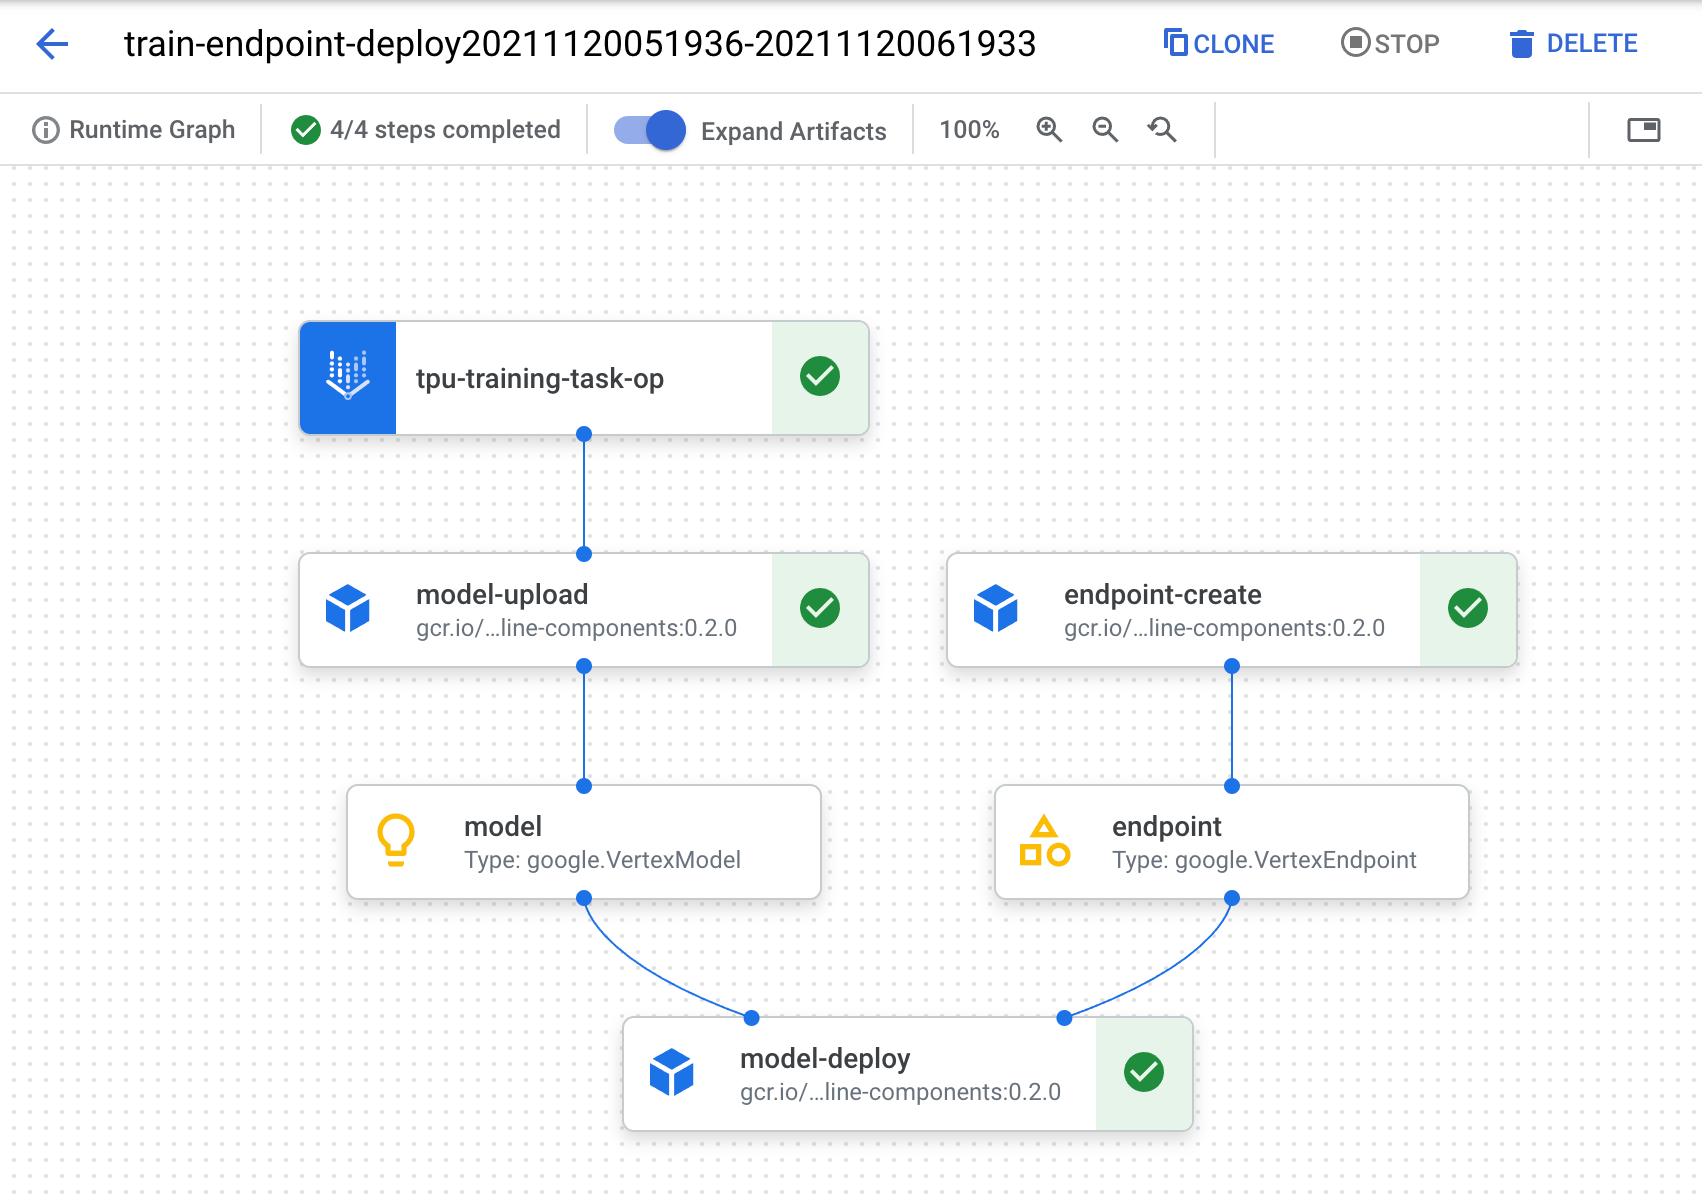


# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial -- *Note:* this is auto-generated and not all resources may be applicable for this tutorial:

- Dataset
- Pipeline
- Model
- Endpoint
- Batch Job
- Custom Job
- Hyperparameter Tuning Job
- Cloud Storage Bucket

In [ ]:
delete_dataset = True
delete_pipeline = True
delete_model = True
delete_endpoint = True
delete_batchjob = True
delete_customjob = True
delete_hptjob = True

# Warning: Setting this to true will delete everything in your bucket
delete_bucket = False

try:
    if delete_model and "DISPLAY_NAME" in globals():
        models = aip.Model.list(
            filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
        )
        model = models[0]
        aip.Model.delete(model)
        print("Deleted model:", model)
except Exception as e:
    print(e)

try:
    if delete_endpoint and "DISPLAY_NAME" in globals():
        endpoints = aip.Endpoint.list(
            filter=f"display_name={DISPLAY_NAME}_endpoint", order_by="create_time"
        )
        endpoint = endpoints[0]
        endpoint.undeploy_all()
        aip.Endpoint.delete(endpoint.resource_name)
        print("Deleted endpoint:", endpoint)
except Exception as e:
    print(e)

if delete_dataset and "DISPLAY_NAME" in globals():
    if "tabular" == "tabular":
        try:
            datasets = aip.TabularDataset.list(
                filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
            )
            dataset = datasets[0]
            aip.TabularDataset.delete(dataset.resource_name)
            print("Deleted dataset:", dataset)
        except Exception as e:
            print(e)

    if "tabular" == "image":
        try:
            datasets = aip.ImageDataset.list(
                filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
            )
            dataset = datasets[0]
            aip.ImageDataset.delete(dataset.resource_name)
            print("Deleted dataset:", dataset)
        except Exception as e:
            print(e)

    if "tabular" == "text":
        try:
            datasets = aip.TextDataset.list(
                filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
            )
            dataset = datasets[0]
            aip.TextDataset.delete(dataset.resource_name)
            print("Deleted dataset:", dataset)
        except Exception as e:
            print(e)

    if "tabular" == "video":
        try:
            datasets = aip.VideoDataset.list(
                filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
            )
            dataset = datasets[0]
            aip.VideoDataset.delete(dataset.resource_name)
            print("Deleted dataset:", dataset)
        except Exception as e:
            print(e)

try:
    if delete_pipeline and "DISPLAY_NAME" in globals():
        pipelines = aip.PipelineJob.list(
            filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
        )
        pipeline = pipelines[0]
        aip.PipelineJob.delete(pipeline.resource_name)
        print("Deleted pipeline:", pipeline)
except Exception as e:
    print(e)

if delete_bucket and "BUCKET_URI" in globals():
    ! gsutil rm -r $BUCKET_URI